In [1]:
!pip install pillow

In [2]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, accuracy_score, f1_score

In [3]:
pip install tensorflow

In [4]:
!pip install kagglehub

In [5]:
import numpy as np
import kagglehub
# Download the dataset
dataset_path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
print("Path to dataset files:", dataset_path)

Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


In [6]:
# Define the paths for training and testing directories
train_dir = os.path.join(dataset_path, "Training")
test_dir = os.path.join(dataset_path, "Testing")

# Check if paths exist
if not os.path.exists(train_dir) or not os.path.exists(test_dir):
    raise Exception("Training or Testing folder not found in the dataset path!")

In [7]:
img_height, img_width, num_channels = 224, 224, 3
batch_size = 32


In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Step 2: Define the Input
input_tensor = Input(shape=(img_height, img_width, num_channels))

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [9]:
# Step 3: Feature Extractor using EfficientNetV2B0
efficient_net = EfficientNetV2B0(input_shape=(img_height, img_width, num_channels),
                                 include_top=False,
                                 weights='imagenet')(input_tensor)
efficient_net = GlobalAveragePooling2D()(efficient_net)

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [10]:
# Step 4: Classification Layers
x = Dropout(0.3)(efficient_net)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(train_data.num_classes, activation='softmax')(x)

# Step 5: Create and Compile the Model
model = Model(inputs=input_tensor, outputs=output)

In [11]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,577,236 (25.09 MB)

 Trainable params: 6,516,628 (24.86 MB)

 Non-trainable params: 60,608 (236.75 KB)

In [12]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
epochs = 20
history = model.fit(train_data, epochs=epochs, validation_data=test_data, callbacks=[reduce_lr, early_stopping])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 255s 898ms/step - accuracy: 0.6151 - loss: 0.9313 - val_accuracy: 0.3089 - val_loss: 2.0528 - learning_rate: 1.0000e-04
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 87s 484ms/step - accuracy: 0.8818 - loss: 0.3285 - val_accuracy: 0.3089 - val_loss: 2.0449 - learning_rate: 1.0000e-04
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 86s 482ms/step - accuracy: 0.9252 - loss: 0.2096 - val_accuracy: 0.4973 - val_loss: 1.2624 - learning_rate: 1.0000e-04
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 86s 482ms/step - accuracy: 0.9517 - loss: 0.1504 - val_accuracy: 0.3898 - val_loss: 2.0790 - learning_rate: 1.0000e-04
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 85s 475ms/step - accuracy: 0.9581 - loss: 0.1106 - val_accuracy: 0.3097 - val_loss: 2.7166 - learning_rate: 1.0000e-04
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.9535 - loss: 0.1229
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
179/179 ━━━━━━━━━━━━━━━━━━━━ 85s 472ms/s

In [19]:
# Save only weights (correct filename)
model.save_weights("brain_tumor_efficient.weights.h5")

# Download the weights file
from google.colab import files
files.download("brain_tumor_efficient.weights.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from google.colab import files

# Upload the image
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

# Process image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = tf.expand_dims(img_array, axis=0) / 255.0

# Predict
prediction = model.predict(img_array)
class_labels = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary Tumor']
predicted_class = class_labels[prediction.argmax()]

print(f"Prediction: {predicted_class}")

Saving image(10).jpg to image(10).jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
Prediction: Pituitary Tumor


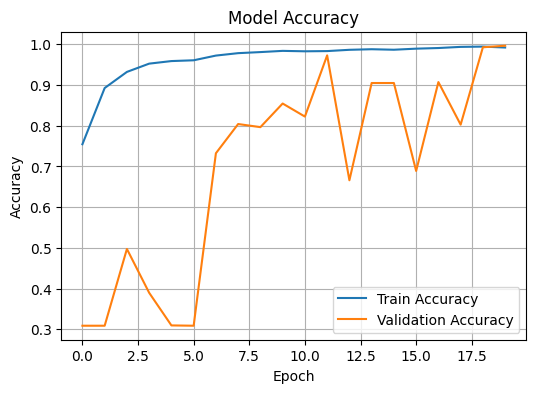

In [21]:
# Plot training & validation accuracy
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()